# Quantum Tomography analysis

This is the analysis code to measure the polarisation of a vector meson using Quantum Tomography.

In [1]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import pickle
import uproot
import numpy as np
import pandas as pd
# import xgboost as xgb
import sklearn

sys.path.insert(0, '../')
# import analysis_utils as au

# avoid pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## A few infos on the libraries

### uproot

uproot is a Python package that provides tools for reading/writing ROOT files using Python and Numpy (does not depend on ROOT) and is primarly intended to stream data into machine learning libraries in Python.

We use uproot for reading and converting ROOT Trees into ***pandas*** **DataFrame**.
For more details: https://github.com/scikit-hep/uproot.

Now we load our data using uproot: signal and background for the training of the models and the unknown data on which we would like to have the model predictions

In [2]:
datatree = uproot.open('AnalysisResults.root')['Data']

In [3]:
datatree.keys()
# IncohMC_std_gener.keys()
# background_treeMine.keys()
# data_treeMine.keys()

[b'fInvariantMassDimuon',
 b'fRapidityDimuon',
 b'fPtDimuon',
 b'fRapiditySingleMuon_0',
 b'fPtSingleMuon_0',
 b'fPhiSingleMuon_0',
 b'fRapiditySingleMuon_1',
 b'fPtSingleMuon_1',
 b'fPhiSingleMuon_1',
 b'fPxSingleMuon_0',
 b'fPySingleMuon_0',
 b'fPzSingleMuon_0',
 b'fEnergySingleMuon_0',
 b'fPxSingleMuon_1',
 b'fPySingleMuon_1',
 b'fPzSingleMuon_1',
 b'fEnergySingleMuon_1']

In [4]:
data_df = datatree.pandas.df()

In [5]:
len(data_df.index)

416

In [6]:
generatedevents = len(data_df.index)
generatedevents

416

## Four-momentum logic

In [7]:
import skhep
from skhep import math


# Levi-Civita symbol
import sympy
from sympy import LeviCivita

Quantum tomography works by defining three coordinate axes in a Lorentz-invariant approach.

Using \\( k_+^\mu \\), \\(k_-^\mu \\) for the positive and the negative muon, respectively, we construct the vector meson 4-vector \\( Q^\mu \\) as:

\\[ Q^\mu = k_+^\mu + k_-^\mu \\]

If \\( p_A^\mu, p_B^\mu \\) are the two beams, the three axes \\( X^\mu, Y^\mu, Z^\mu \\) are defined as:

\\[ Z^\mu = p_A^\mu  Q{\cdot}p_B - p_B^\mu Q{\cdot}p_A \\]

\\[ Y^\mu = \epsilon^{\mu\nu\alpha\beta}p_{A \nu}p_{B \alpha}Q_\beta \\]

\\[ X^\mu = Q^\mu - p_A^\mu \frac{Q^2}{2Q{\cdot}p_A} - p_B^\mu \frac{Q^2}{2Q{\cdot}p_B} \\]





In [8]:
def CosThetaTrueCollinsSoper( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
    pA            = math.LorentzVector( 0, 0,-1, 1 )
    pB            = math.LorentzVector( 0, 0, 1, 1 )
#     pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
#     pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
    print( "X  = ", x )
    print( "Y  = ", y )
    print( "Z  = ", z )
    print( "Xh = ", xhat )
    print( "Yh = ", yhat )
    print( "Zh = ", zhat )
    print( "XY = ", xhat.dot(yhat) )
    print( "XZ = ", xhat.dot(zhat) )
    print( "YZ = ", yhat.dot(zhat) )
    print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
#     NormOfdiff = diff.mag
    NormOfdiff = math.sqrt(-diff.dot(diff))
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );


    return cosThetaCS

    

In [9]:
help(math.atan2)

Help on built-in function atan2 in module math:

atan2(y, x, /)
    Return the arc tangent (measured in radians) of y/x.
    
    Unlike atan(y/x), the signs of both x and y are considered.



In [10]:
def PhiTrueCollinsSoper( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
    
    positiveMuon  = math.LorentzVector(px1, py1, pz1, E1)
    negativeMuon  = math.LorentzVector(px2, py2, pz2, E2)
    Q             = positiveMuon + negativeMuon
    
    
    # Beam coordinates     

    HalfSqrtSnn   = 2510.
    MassOfLead208 = 193.6823
    MomentumBeam  = math.sqrt( HalfSqrtSnn*HalfSqrtSnn*208*208 - MassOfLead208*MassOfLead208 )
    
#     pA            = math.LorentzVector( 0, 0,-1, 1 )
#     pB            = math.LorentzVector( 0, 0, 1, 1 )
    pA            = math.LorentzVector( 0, 0,-MomentumBeam, HalfSqrtSnn*208 )
    pB            = math.LorentzVector( 0, 0, MomentumBeam, HalfSqrtSnn*208 )

    
    # Z axis
    
    z       = pA * (Q.dot(pB)) - pB * (Q.dot(pA))
#     NormOfz = z.mag
    NormOfz = math.sqrt(-z.dot(z))
    zhat    = math.LorentzVector( z.px / NormOfz, z.py / NormOfz, z.pz / NormOfz, z.e / NormOfz )
    

    # X axis
    
    x       = Q - pA*(Q.mag2 / ( 2.*( Q.dot(pA)) ) ) - pB*(Q.mag2 / ( 2.*( Q.dot(pB)) ) );
#     NormOfx = x.mag
    NormOfx = math.sqrt(-x.dot(x))
    xhat    = math.LorentzVector( x.px / NormOfx, x.py / NormOfx, x.pz / NormOfx, x.e / NormOfx )

    
    # Y axis
    
#     pAlower = [ 0, 0, 1, 1 ]
#     pBlower = [ 0, 0,-1, 1 ]
    pAlower = [ 0, 0, MomentumBeam, HalfSqrtSnn*208 ]
    pBlower = [ 0, 0,-MomentumBeam, HalfSqrtSnn*208 ]
    Qlower  = [ -Q.px, -Q.py, -Q.pz, -Q.e ]
#     print(Qlower)
    ComponentsY = [0,0,0,0]
#     print(LeviCivita(0,1,2,3))
    for mu in range(0,4):
        for nu in range(0,4):
            for alpha in range(0,4):
                for beta in range(0,4):
                    tensor = LeviCivita(mu, nu, alpha, beta) 
                    ComponentsY[mu] += tensor*pAlower[nu]*pBlower[alpha]*Qlower[beta]
    y       = math.LorentzVector(ComponentsY[0], ComponentsY[1], ComponentsY[2], ComponentsY[3])
#     NormOfy = y.mag
    NormOfy = math.sqrt(-y.dot(y))
    yhat    = math.LorentzVector( y.px / NormOfy, y.py / NormOfy, y.pz / NormOfy, y.e / NormOfy )

    
    # Orthogonality check
    
#     print( "XY = ", xhat.dot(yhat) )
#     print( "XZ = ", xhat.dot(zhat) )
#     print( "YZ = ", yhat.dot(zhat) )
#     print( "ZQ = ", zhat.dot(Q)    )
    
    
    # Lepton momentum difference
    
    diff       = positiveMuon - negativeMuon
#     NormOfdiff = diff.mag
    NormOfdiff = math.sqrt(-diff.dot(diff))
    diffhat    = math.LorentzVector( diff.px / NormOfdiff, diff.py / NormOfdiff, diff.pz / NormOfdiff, diff.e / NormOfdiff )
    
    
    # Computing the angles
    cosThetaCS       = zhat.dot(diffhat)
    SinThetaCosPhiCS = xhat.dot(diffhat)
    SinThetaSinPhiCS = yhat.dot(diffhat)



    SinThetaCS       = math.sqrt( 1 - cosThetaCS*cosThetaCS );
#     PhiCS            = math.acos( SinThetaCosPhiCS / SinThetaCS );
    PhiCS            = math.atan2( SinThetaSinPhiCS, SinThetaCosPhiCS );


    return PhiCS

    

#### Small test procedure
Here we are testing the few functions using our data.

In [11]:
data_df.iloc[4]

fInvariantMassDimuon      2.930918
fRapidityDimuon          -3.074141
fPtDimuon                 0.082999
fRapiditySingleMuon_0    -2.680881
fPtSingleMuon_0           1.366783
fPhiSingleMuon_0          3.538862
fRapiditySingleMuon_1    -3.481849
fPtSingleMuon_1           1.336783
fPhiSingleMuon_1          0.454529
fPxSingleMuon_0          -1.260339
fPySingleMuon_0          -0.528812
fPzSingleMuon_0          -9.929302
fEnergySingleMuon_0      10.023487
fPxSingleMuon_1           1.201056
fPySingleMuon_1           0.586901
fPzSingleMuon_1         -21.715403
fEnergySingleMuon_1      21.756766
Name: 4, dtype: float64

In [12]:
CosThetaTest = CosThetaTrueCollinsSoper( 1.201056, 0.586901, 21.715403, 21.756766, -1.260339, -0.528812, -9.929302, 10.023487 )

X  =  (-0.0592830000000002, 0.05808900000000006, 9.320944201007819e-05, 0.0002513316022891843)
Y  =  (-31666347903.0162, -32317239111.2691, 0, 0)
Z  =  (0.0, 0.0, -63.560506, -23.572201999999997)
Xh =  (-0.714265893086271, 0.699880091484714, 0.0011230255780139546, 0.0030281462032941495)
Yh =  (-0.699877324006233, -0.714263068723194, 0, 0)
Zh =  (0.0, 0.0, -1.0767881005148563, -0.39934022263026814)
XY =  1.11022302462516e-16
XZ =  -1.2420620087993939e-15
YZ =  0
ZQ =  0.0


In [13]:
CosThetaTest

0.995798810540499

In [14]:
LeviCivita(0,1,3,2)

-1

## Adding the two columns to the dataframe

Now we are adding two new columns to the dataframe:
\\( \cos\theta \\) and \\( \phi \\).

In [15]:
def CosThetaTrueCollinsSoperOne( px1 ):
    return px1
def CosThetaTrueCollinsSoperTwo( px1, py1 ):
    return px1+px1
def CosThetaTrueCollinsSoperThree( px1, py1, pz1 ):
    return px1+py1+pz1
def CosThetaTrueCollinsSoperFour( px1, py1, pz1, E1 ):
        return px1+py1+pz1+E1

# def CosThetaTrueCollinsSoperOne( px1, py1, pz1, E1, px2, py2, pz2, E2 ):
# def CosThetaTrueCollinsSoperOne( px1, py1, pz1, E1, px2, py2, pz2, E2 ):


In [16]:
# data_df['CosThetaOne']   = data_df.apply(lambda x: CosThetaTrueCollinsSoperOne(x['fPxSingleMuon_0']   ), axis=1)
# data_df['CosThetaTwo']   = data_df.apply(lambda x: CosThetaTrueCollinsSoperTwo(x['fPxSingleMuon_0'], x['fPySingleMuon_0']   ), axis=1)
# data_df['CosThetaThree'] = data_df.apply(lambda x: CosThetaTrueCollinsSoperThree(x['fPxSingleMuon_0'], x['fPySingleMuon_0'], x['fPzSingleMuon_0']  ), axis=1)



# data_df['Sum']      = data_df.apply(lambda x: x['fPxSingleMuon_0']+ x['fPySingleMuon_0']   , axis=1)
data_df['CosTheta'] = data_df.apply(lambda x: CosThetaTrueCollinsSoper(x['fPxSingleMuon_0'], x['fPySingleMuon_0'], x['fPzSingleMuon_0'], x['fEnergySingleMuon_0'], x['fPxSingleMuon_1'], x['fPySingleMuon_1'], x['fPzSingleMuon_1'],  x['fEnergySingleMuon_1']   ), axis=1)
data_df['Phi']      = data_df.apply(lambda x: PhiTrueCollinsSoper(     x['fPxSingleMuon_0'], x['fPySingleMuon_0'], x['fPzSingleMuon_0'], x['fEnergySingleMuon_0'], x['fPxSingleMuon_1'], x['fPySingleMuon_1'], x['fPzSingleMuon_1'],  x['fEnergySingleMuon_1']   ), axis=1)


X  =  (0.03969339699336133, 0.08083059946493365, -0.030711659130193456, 0.030816761854713062)
Y  =  (-44063590074.9873, 21638260576.7756, 0, 0)
Z  =  (0.0, 0.0, -77.28632771548229, 77.02273728215545)
Xh =  (0.44096467087328617, 0.8979689668663584, -0.34118411842108953, 0.34235173298261035)
Yh =  (-0.897610843821577, 0.440788807768434, 0, 0)
Zh =  (0.0, 0.0, -12.118312014601141, 12.076981662784222)
XY =  0
XZ =  -1.7763568394002505e-15
YZ =  0
ZQ =  -1.1368683772161603e-13
X  =  (-0.18183367380085247, 0.04980512940777601, -0.39973500644454674, 0.40031142441187584)
Y  =  (-27150519981.0872, -99123902547.1492, 0, 0)
Z  =  (0.0, 0.0, -61.70807755678412, 61.61922262418925)
Xh =  (-0.9707932034647999, 0.2659049895219524, -2.1341483089008824, 2.137225751232334)
Yh =  (-0.264174384214233, -0.964474932139260, 0, 0)
Zh =  (0.0, 0.0, -18.641104183103835, 18.61426241260532)
XY =  0
XZ =  -7.105427357601002e-15
YZ =  0
ZQ =  0.0
X  =  (-0.03461770711083345, 0.005716640420215885, -0.0055198295681456

X  =  (0.12791876355371912, -0.13900932721572434, -0.0457507636109423, 0.046128371753295344)
Y  =  (75778851716.8025, 69732997125.3720, 0, 0)
Z  =  (0.0, 0.0, -94.89591456693094, 94.1190939540518)
Xh =  (0.677472453593511, -0.7362093516614666, -0.24230129510488574, 0.24430115116657583)
Yh =  (0.735851397404448, 0.677143057955940, 0, 0)
Zh =  (0.0, 0.0, -7.831392666937646, 7.76728466735736)
XY =  5.55111512312578e-17
XZ =  2.220446049250313e-16
YZ =  0
ZQ =  0.0
X  =  (0.04467869916833811, 0.10435054470574201, -0.028911660575729498, 0.02909462357810408)
Y  =  (-56885135783.3887, 24355923354.1427, 0, 0)
Z  =  (0.0, 0.0, -70.64742405479593, 70.20315417859713)
Xh =  (0.3937617170327535, 0.9196608321522995, -0.2548038622985466, 0.2564163493966387)
Yh =  (-0.919282011578931, 0.393599521325160, 0, 0)
Zh =  (0.0, 0.0, -8.930866154426083, 8.874703953838308)
XY =  -5.55111512312578e-17
XZ =  4.440892098500626e-16
YZ =  0
ZQ =  -5.684341886080802e-14
X  =  (-0.0837863041667204, 0.0512865910102084

XY =  -2.77555756156289e-17
XZ =  -8.881784197001252e-16
YZ =  0
ZQ =  0.0
X  =  (-0.3253660433206713, -0.5279507758379425, -3.5599570446175903, 3.5656682726212097)
Y  =  (287804454257.288, -177368422999.539, 0, 0)
Z  =  (0.0, 0.0, -67.39414687902479, 67.28619983810376)
Xh =  (-0.554825944735571, -0.9002807576003556, -6.070567507105679, 6.080306499658092)
Yh =  (0.851317514052201, -0.524650826996376, 0, 0)
Zh =  (0.0, 0.0, -17.675214636909477, 17.646903764140017)
XY =  0
XZ =  2.842170943040401e-14
YZ =  0
ZQ =  1.1368683772161603e-13
X  =  (0.017668398881925063, 0.1364530338153347, -0.0795770470365649, 0.07979237999997266)
Y  =  (-74385326674.9026, 9631662894.59795, 0, 0)
Z  =  (0.0, 0.0, -88.03660157717914, 87.79902021532519)
Xh =  (0.12852792192658957, 0.9926210628403452, -0.578879419522692, 0.5804458488575768)
Yh =  (-0.991720988082064, 0.128411377212205, 0, 0)
Zh =  (0.0, 0.0, -13.620832582052183, 13.584074507609795)
XY =  0
XZ =  0.0
YZ =  0
ZQ =  0.0
X  =  (-0.0614006676724792, 

X  =  (0.10817135966375524, -0.019587864264329125, -0.03310366597504863, 0.033251758726407316)
Y  =  (10678030685.1780, 58967995803.9347, 0, 0)
Z  =  (0.0, 0.0, -81.7845451034043, 81.4203027665512)
Xh =  (0.9843975049720661, -0.1782564698222791, -0.3012550299132966, 0.3026027261555838)
Yh =  (0.178183980006868, 0.983997189665149, 0, 0)
Zh =  (0.0, 0.0, -10.6074136028012, 10.56017155830775)
XY =  0
XZ =  0.0
YZ =  0
ZQ =  5.684341886080802e-14
X  =  (0.019504573268252168, 0.01809502498370441, -0.0032668248202801023, 0.0032779292993860495)
Y  =  (-9864231721.11334, 10632625846.7583, 0, 0)
Z  =  (0.0, 0.0, -63.85345259096255, 63.637139404991316)
Xh =  (0.7331377495345615, 0.6801556594892637, -0.12279338614201965, 0.12321078121698593)
Yh =  (-0.680120742671101, 0.733100112800776, 0, 0)
Zh =  (0.0, 0.0, -12.159166878067317, 12.117975869289776)
XY =  0
XZ =  1.7763568394002505e-15
YZ =  0
ZQ =  -5.684341886080802e-14
X  =  (0.045583986009080535, 0.013575932937616608, -0.009846303271941519, 0

X  =  (0.05436397708027041, 0.027188855149791413, -0.015019158759630419, 0.015065860227890165)
Y  =  (-14821596967.7221, 29635707476.7243, 0, 0)
Z  =  (0.0, 0.0, -79.2354350269035, 78.9898193701815)
Xh =  (0.8945521060661245, 0.44738904219352094, -0.24713828570582652, 0.24790675223516911)
Yh =  (-0.447303967356762, 0.894381999364310, 0, 0)
Zh =  (0.0, 0.0, -12.710233284189771, 12.670833837539087)
XY =  5.55111512312578e-17
XZ =  2.220446049250313e-15
YZ =  0
ZQ =  0.0
X  =  (-0.1734861045805004, 0.4878897965238077, -1.1858626694796157, 1.1907459276324943)
Y  =  (-265965811686.458, -94573350272.6019, 0, 0)
Z  =  (0.0, 0.0, -55.02162959158092, 54.79598546796676)
Xh =  (-0.3425287767278899, 0.9632834605711851, -2.3413522975014, 2.350993740806595)
Yh =  (-0.942206047981118, -0.335033973124822, 0, 0)
Zh =  (0.0, 0.0, -11.05313389728295, 11.007804910665222)
XY =  -5.55111512312578e-17
XZ =  0.0
YZ =  0
ZQ =  0.0
X  =  (-0.2472664049433897, 0.43446494806445773, -0.7580288075347095, 0.76087664

X  =  (-0.03632062941963543, 0.011027288082554376, -0.005005593831981306, 0.005025588770152675)
Y  =  (-6011360857.45926, -19799646873.9124, 0, 0)
Z  =  (0.0, 0.0, -72.20132842153261, 71.91406633867915)
Xh =  (-0.9569370608064183, 0.2905351811078595, -0.13188202753384462, 0.132408832759152)
Yh =  (-0.290514957641137, -0.956870450681161, 0, 0)
Zh =  (0.0, 0.0, -11.221498293888047, 11.176852148960918)
XY =  -5.55111512312578e-17
XZ =  1.1102230246251565e-15
YZ =  0
ZQ =  -5.684341886080802e-14
X  =  (-0.07414647716670326, -0.007067171025677332, -0.026410975426493982, 0.02644924926338596)
Y  =  (3852562385.11962, -40419840963.7602, 0, 0)
Z  =  (0.0, 0.0, -145.05109095543293, 144.84119230232005)
Xh =  (-0.9956699427661961, -0.0949009317709697, -0.35465763710087117, 0.3551715942090693)
Yh =  (0.0948836255427120, -0.995488371405648, 0, 0)
Zh =  (0.0, 0.0, -18.5950712267946, 18.568162912080574)
XY =  1.38777878078145e-17
XZ =  8.881784197001252e-16
YZ =  0
ZQ =  2.2737367544323206e-13
X  =  (

X  =  (-0.06133399630609648, 0.07580198449924302, -0.02200694215597264, 0.02221493536995868)
Y  =  (-41322315978.7923, -33435309013.9468, 0, 0)
Z  =  (0.0, 0.0, -45.927070252596195, 45.49706589779095)
Xh =  (-0.6293198274367785, 0.7777691765975361, -0.22580307617475862, 0.22793719854435718)
Yh =  (-0.777392878422473, -0.629015351623490, 0, 0)
Zh =  (0.0, 0.0, -7.324903076125452, 7.2563217317475734)
XY =  5.55111512312578e-17
XZ =  1.3322676295501878e-15
YZ =  0
ZQ =  2.842170943040401e-14
X  =  (0.03186768388434508, -0.0035047161824246498, -0.003173909240332909, 0.0031902904951499472)
Y  =  (1910543509.68324, 17372190341.4590, 0, 0)
Z  =  (0.0, 0.0, -62.90592094590319, 62.58291652919549)
Xh =  (0.994057242347132, -0.10932355536581267, -0.09900460536623189, 0.09951559025765697)
Yh =  (0.109318010852055, 0.994006827191519, 0, 0)
Zh =  (0.0, 0.0, -9.880632498542878, 9.82989819740071)
XY =  1.38777878078145e-17
XZ =  6.328271240363392e-15
YZ =  0
ZQ =  1.1368683772161603e-13
X  =  (0.03889

X  =  (0.27845729445027034, 0.541556460243823, -1.3650698542909259, 1.3700578354768747)
Y  =  (-295221389233.880, 151796821466.971, 0, 0)
Z  =  (0.0, 0.0, -74.47865354714034, 74.20749848125317)
Xh =  (0.46592453496349884, 0.9061513091036815, -2.284082872775227, 2.292428938260988)
Yh =  (-0.889326173965675, 0.457273393386903, 0, 0)
Zh =  (0.0, 0.0, -11.729721327069358, 11.687016831112453)
XY =  0
XZ =  -7.105427357601002e-15
YZ =  0
ZQ =  -5.684341886080802e-14
X  =  (0.36729822749364405, -0.26965005770994566, -1.0451962720554668, 1.0467808085765533)
Y  =  (146995688331.896, 200227124859.696, 0, 0)
Z  =  (0.0, 0.0, -131.12755482010783, 130.92906398245503)
Xh =  (0.8126060467746288, -0.5965704460472008, -2.312379279731944, 2.315884888694874)
Yh =  (0.591788909667454, 0.806092976271724, 0, 0)
Zh =  (0.0, 0.0, -18.181351536757386, 18.15383000094333)
XY =  0
XZ =  0.0
YZ =  0
ZQ =  -4.547473508864641e-13
X  =  (-0.022090732922904532, 0.07042913129635009, -0.01999313597660307, 0.020073306086

X  =  (0.1869305021192451, 0.04826349195983448, -0.28071268270647903, 0.2809536852464591)
Y  =  (-26310119427.3364, 101902362130.412, 0, 0)
Z  =  (0.0, 0.0, -154.7218975164884, 154.58917681464283)
Xh =  (0.9700110471830036, 0.2504466625077751, -1.4566611667044163, 1.457911765849711)
Yh =  (-0.249991472157958, 0.968248038391143, 0, 0)
Zh =  (0.0, 0.0, -24.14819718350875, 24.127482819673087)
XY =  5.55111512312578e-17
XZ =  0.0
YZ =  0
ZQ =  2.2737367544323206e-13
X  =  (0.08575748224954793, 0.004932224398468299, -0.022052819573283797, 0.022196660091913303)
Y  =  (-2688728222.85875, 46749406397.0961, 0, 0)
Z  =  (0.0, 0.0, -51.46434613839993, 51.13084289021651)
Xh =  (0.9987810517344115, 0.057443527291967125, -0.2568398435837908, 0.2585150931446483)
Yh =  (-0.0574187464557043, 0.998350182829379, 0, 0)
Zh =  (0.0, 0.0, -8.79818171095454, 8.741167051313855)
XY =  0
XZ =  -4.440892098500626e-16
YZ =  0
ZQ =  2.842170943040401e-14
X  =  (-0.042089393853078194, 0.12315949403701643, -0.0532810

X  =  (0.042102024670339966, 0.10313676208315697, -0.07711232083664474, 0.07742589500092759)
Y  =  (-56223460374.8705, 22951287862.2864, 0, 0)
Z  =  (0.0, 0.0, -39.65554026218328, 39.49493568800625)
Xh =  (0.37867852781749245, 0.9276436830608482, -0.693571873553676, 0.6963922557994705)
Yh =  (-0.925830723368663, 0.377938449574342, 0, 0)
Zh =  (0.0, 0.0, -11.122390800449349, 11.077345219768151)
XY =  0
XZ =  0.0
YZ =  0
ZQ =  -2.842170943040401e-14
X  =  (0.5285173531697674, -0.09066187417465343, -1.0378907602582417, 1.0417003880069458)
Y  =  (49422962164.1628, 288113315399.733, 0, 0)
Z  =  (0.0, 0.0, -75.61813216524027, 75.34158726046869)
Xh =  (0.9994686037069535, -0.17144885829640855, -1.9627344735877477, 1.9699387844846454)
Yh =  (0.169070516636341, 0.985603957177689, 0, 0)
Zh =  (0.0, 0.0, -11.703414187567345, 11.660613347751164)
XY =  0
XZ =  -1.0658141036401503e-14
YZ =  0
ZQ =  -1.1368683772161603e-13
X  =  (-0.06855150226984152, 0.014514204572312506, -0.015275396038322592, 0.01

X  =  (-0.10345112491487052, 0.15765519257644312, -0.17069909615343953, 0.1711436332738024)
Y  =  (-85943365815.2603, -56394830561.9424, 0, 0)
Z  =  (0.0, 0.0, -80.09125126111032, 79.88321819835004)
Xh =  (-0.5497951121174403, 0.8378647825220766, -0.9071871261453596, 0.9095496363271617)
Yh =  (-0.836072467422864, -0.548619020101787, 0, 0)
Zh =  (0.0, 0.0, -13.883327159585727, 13.847265904144786)
XY =  -5.55111512312578e-17
XZ =  3.552713678800501e-15
YZ =  0
ZQ =  0.0
X  =  (-0.030690265501072567, -0.027109729415031564, -0.0085894896107312, 0.008613094885017651)
Y  =  (14778462759.0941, -16730338353.0944, 0, 0)
Z  =  (0.0, 0.0, -71.13371106523553, 70.93876014653276)
Xh =  (-0.7495640387921697, -0.662114776106573, -0.20978549447733033, 0.21036201815485703)
Yh =  (0.662034600299509, -0.749473273710457, 0, 0)
Zh =  (0.0, 0.0, -13.516301045625527, 13.479257915626427)
XY =  0
XZ =  -1.3322676295501878e-15
YZ =  0
ZQ =  0.0
X  =  (-0.024010265572069978, -0.06218515702965133, -0.0170513921254

X  =  (-0.009131375953158771, 0.02896357688549056, -0.001463577992275894, 0.0014733593339567863)
Y  =  (-15789059928.2429, -4977832769.81806, 0, 0)
Z  =  (0.0, 0.0, -94.60280863371065, 93.97475926795568)
Xh =  (-0.3006863790891061, 0.9537394039892139, -0.04819404756407038, 0.04851613661480576)
Yh =  (-0.953724550182911, -0.300681696114685, 0, 0)
Zh =  (0.0, 0.0, -8.692848772899543, 8.635138666431542)
XY =  0
XZ =  -6.994405055138486e-15
YZ =  0
ZQ =  0.0
X  =  (0.05207020868116552, 0.08163588365480934, -0.058556592854485105, 0.05863247952281526)
Y  =  (-44502578684.1457, 28385294005.4131, 0, 0)
Z  =  (0.0, 0.0, -123.62903339244266, 123.4690231808776)
Xh =  (0.5380132542529151, 0.8434993548397897, -0.6050335475417447, 0.605817643369605)
Yh =  (-0.843099220741008, 0.537758034794373, 0, 0)
Zh =  (0.0, 0.0, -19.661287741841885, 19.635840589786373)
XY =  0
XZ =  1.7763568394002505e-15
YZ =  0
ZQ =  0.0
X  =  (0.06200095863985866, -0.0731648878026952, -0.03220354966940989, 0.0323035599800093

X  =  (0.058607555098666, -0.02910707887218328, -0.013438172632193782, 0.013503296376184012)
Y  =  (15867287885.9524, 31949030444.6547, 0, 0)
Z  =  (0.0, 0.0, -65.91172492248386, 65.59384562988551)
Xh =  (0.8958098616446113, -0.44489841375353306, -0.20540095122780372, 0.2063963603008397)
Yh =  (0.444807258338356, 0.895626318801271, 0, 0)
Zh =  (0.0, 0.0, -10.194348672937048, 10.145183333257874)
XY =  5.55111512312578e-17
XZ =  -2.220446049250313e-15
YZ =  0
ZQ =  0.0
X  =  (0.2153058182598423, -0.1862306492940814, -0.5465218871792482, 0.5473440103044757)
Y  =  (101520847849.868, 117370740528.495, 0, 0)
Z  =  (0.0, 0.0, -98.64624186025857, 98.49807296624805)
Xh =  (0.7605598222155809, -0.6578528655796043, -1.9305683084157506, 1.933472427881801)
Yh =  (0.654192550303107, 0.756328042008173, 0, 0)
Zh =  (0.0, 0.0, -18.251976299596535, 18.224561416973348)
XY =  -5.55111512312578e-17
XZ =  0.0
YZ =  0
ZQ =  0.0
X  =  (-0.051998923422067134, 0.03427762385744715, -0.016261009624322476, 0.01631

X  =  (-0.040949957270939794, -0.0658449111975612, -0.06611198789048797, 0.06632501782335157)
Y  =  (35894366672.2646, -22323255582.9025, 0, 0)
Z  =  (0.0, 0.0, -28.268903367322224, 28.178106217406523)
Xh =  (-0.5293574307848963, -0.8511728789161864, -0.8546253619323427, 0.8573791860009451)
Yh =  (0.849173493293070, -0.528113982288336, 0, 0)
Zh =  (0.0, 0.0, -12.486835301970602, 12.446728721175667)
XY =  -5.55111512312578e-17
XZ =  -1.7763568394002505e-15
YZ =  0
ZQ =  -2.842170943040401e-14
X  =  (-0.0052335286568218065, 0.027078105273580233, -0.003911446717708107, 0.003919282236602366)
Y  =  (-14761223332.2606, -2852979724.34237, 0, 0)
Z  =  (0.0, 0.0, -97.16965735473462, 96.97539354820356)
Xh =  (-0.1897711017261185, 0.9818694436162142, -0.14183156368025807, 0.14211568461484414)
Yh =  (-0.981829839678275, -0.189763447263517, 0, 0)
Zh =  (0.0, 0.0, -15.822370946513832, 15.790738499800604)
XY =  -2.77555756156289e-17
XZ =  -2.220446049250313e-15
YZ =  0
ZQ =  1.1368683772161603e-13
X 

XY =  0
XZ =  3.552713678800501e-15
YZ =  0
ZQ =  0.0
X  =  (0.0010035665542884598, 0.22481157197553792, -0.16546518816625028, 0.16635866130404647)
Y  =  (-122552659725.617, 547079268.913727, 0, 0)
Z  =  (0.0, 0.0, -56.71948703540528, 56.414860046594086)
Xh =  (0.0044771405587851415, 1.0029359813505894, -0.738178152550508, 0.7421641411292611)
Yh =  (-0.999990036348077, 0.00446398975943209, 0, 0)
Zh =  (0.0, 0.0, -9.661640377801259, 9.609749985819592)
XY =  0
XZ =  8.881784197001252e-16
YZ =  0
ZQ =  0.0
X  =  (-0.6601764088927691, -0.6774666930508494, -2.7437050853691014, 2.7570265984630984)
Y  =  (369310816072.820, -359885276753.986, 0, 0)
Z  =  (0.0, 0.0, -67.33176561935181, 67.00642925957925)
Xh =  (-0.7283699217649423, -0.7474462212962092, -3.0271185571869887, 3.0418161278959133)
Yh =  (0.716186967896792, -0.697908466071876, 0, 0)
Zh =  (0.0, 0.0, -10.18483382144985, 10.135622327738378)
XY =  0
XZ =  3.552713678800501e-15
YZ =  0
ZQ =  5.684341886080802e-14
X  =  (-0.16734965997078

X  =  (0.09621051711256573, -0.2714637581723798, -0.1412451424660671, 0.1422890961872926)
Y  =  (147984399961.212, 52447721716.9446, 0, 0)
Z  =  (0.0, 0.0, -79.7491752754643, 79.16406755797695)
Xh =  (0.3346517772310611, -0.9442401085935418, -0.49129699506988994, 0.4949282089812168)
Yh =  (0.942553882445353, 0.334054155320946, 0, 0)
Zh =  (0.0, 0.0, -8.270432895805133, 8.209753972197685)
XY =  5.55111512312578e-17
XZ =  8.881784197001252e-16
YZ =  0
ZQ =  0.0
X  =  (0.15482097266366157, 0.1280535004900105, -0.12813314057836683, 0.12844744127750468)
Y  =  (-69806446947.1969, 84398333299.7790, 0, 0)
Z  =  (0.0, 0.0, -128.59239855780612, 128.27774315970277)
Xh =  (0.7713465511385381, 0.637986083311632, -0.6383828648744212, 0.6399487687447392)
Yh =  (-0.637348497812980, 0.770575688907675, 0, 0)
Zh =  (0.0, 0.0, -14.303452925899766, 14.268453511275514)
XY =  -5.55111512312578e-17
XZ =  0.0
YZ =  0
ZQ =  -1.1368683772161603e-13
X  =  (-0.05491324302661149, 0.05399775347215913, -0.04928705134

X  =  (-0.37537631179522446, 0.374290518774766, -1.6149303726115634, 1.6218472011289407)
Y  =  (-204038867674.123, -204630771468.929, 0, 0)
Z  =  (0.0, 0.0, -40.71248137741368, 40.53885142509236)
Xh =  (-0.7381456747947003, 0.7360105549254132, -3.1756235867331695, 3.189224943273174)
Yh =  (-0.706081890157735, -0.708130188871566, 0, 0)
Zh =  (0.0, 0.0, -10.839269217712593, 10.793042072282113)
XY =  1.11022302462516e-16
XZ =  7.105427357601002e-15
YZ =  0
ZQ =  0.0
X  =  (0.0686507739396025, 0.014687089925939312, -0.018429034834996486, 0.018520886527744182)
Y  =  (-8006446991.30090, 37423940701.0409, 0, 0)
Z  =  (0.0, 0.0, -53.7920537719116, 53.5252797604233)
Xh =  (0.9782086480421689, 0.2092771509432169, -0.2625963294532427, 0.26390512926753407)
Yh =  (-0.209205083312650, 0.977871787667559, 0, 0)
Zh =  (0.0, 0.0, -10.05336451563136, 10.003506289504484)
XY =  -2.77555756156289e-17
XZ =  -1.3322676295501878e-15
YZ =  0
ZQ =  0.0
X  =  (0.6354425363344159, -0.19707204265797684, -1.60590447

X  =  (0.039958599671972746, 0.11751768293613662, -0.04729907908342185, 0.04756928643115316)
Y  =  (-64063003883.9031, 21782831843.0346, 0, 0)
Z  =  (0.0, 0.0, -57.18193320953682, 56.857123239283)
Xh =  (0.3221895577973533, 0.9475549846437886, -0.3813764621185828, 0.3835551667427143)
Yh =  (-0.946766391531302, 0.321921418776070, 0, 0)
Zh =  (0.0, 0.0, -9.395444909439844, 9.342076056547553)
XY =  0
XZ =  -8.881784197001252e-16
YZ =  0
ZQ =  0.0
X  =  (0.07944700007223993, -0.1253906594774108, -0.07029320840125942, 0.07065595113961441)
Y  =  (68354839071.0861, 43309341598.8999, 0, 0)
Z  =  (0.0, 0.0, -60.90087739478573, 60.5882165264782)
Xh =  (0.5358323570528788, -0.8457005621244675, -0.4740943711934688, 0.476540899021075)
Yh =  (0.844718827821421, 0.535210334283638, 0, 0)
Zh =  (0.0, 0.0, -9.881392224025157, 9.830661843692155)
XY =  5.55111512312578e-17
XZ =  -8.881784197001252e-16
YZ =  0
ZQ =  0.0
X  =  (0.033342017761754716, -0.09456356362522267, -0.08040529733407398, 0.080520307871

X  =  (0.040478031005545034, 0.11889356863746756, -0.08452310509807083, 0.08474152989632765)
Y  =  (-64813047356.7315, 22065992051.0021, 0, 0)
Z  =  (0.0, 0.0, -72.31096139805777, 72.12457690423935)
Xh =  (0.32266801822502095, 0.9477524281429806, -0.673770490775196, 0.6755116499925273)
Yh =  (-0.946641101387560, 0.322289660342599, 0, 0)
Zh =  (0.0, 0.0, -13.936772609175726, 13.90085000134419)
XY =  5.55111512312578e-17
XZ =  1.7763568394002505e-15
YZ =  0
ZQ =  5.684341886080802e-14
X  =  (-0.0711176817229906, -0.020310404699647233, -0.023613572071714044, 0.02373969944748528)
Y  =  (11071912776.4307, -38768738513.2502, 0, 0)
Z  =  (0.0, 0.0, -43.48625633169554, 43.255216869491505)
Xh =  (-0.9620812008017279, -0.274759498183822, -0.3194448022428797, 0.32115105551486645)
Yh =  (0.274609462520955, -0.961555845020949, 0, 0)
Zh =  (0.0, 0.0, -9.713942805762064, 9.662333301724619)
XY =  5.55111512312578e-17
XZ =  -4.440892098500626e-16
YZ =  0
ZQ =  0.0
X  =  (-0.08492449577752897, 0.0151843

X  =  (-0.2927103970209384, 0.30785270008152743, -0.2561745471516512, 0.2577351080920427)
Y  =  (-167821286365.139, -159566686754.721, 0, 0)
Z  =  (0.0, 0.0, -115.98434086936922, 115.28206699834831)
Xh =  (-0.6905954666804982, 0.726320900266641, -0.6043959584025462, 0.6080778102324828)
Yh =  (-0.724705105844068, -0.689059148087839, 0, 0)
Zh =  (0.0, 0.0, -9.101014918132657, 9.04590916050306)
XY =  -1.11022302462516e-16
XZ =  -8.881784197001252e-16
YZ =  0
ZQ =  0.0
X  =  (-0.5637882076877474, -0.7476150258408842, -4.704329019395137, 4.711246536580826)
Y  =  (407551128540.685, -307340693216.584, 0, 0)
Z  =  (0.0, 0.0, -126.84168477829368, 126.655443296872)
Xh =  (-0.6257931403274232, -0.8298370707250645, -5.221706999255297, 5.229385298914412)
Yh =  (0.798419939058935, -0.602100988965411, 0, 0)
Zh =  (0.0, 0.0, -18.46023696008959, 18.43313181807849)
XY =  -1.11022302462516e-16
XZ =  0.0
YZ =  0
ZQ =  0.0
X  =  (0.019495292072219783, 0.07050652525157175, -0.016924876973969147, 0.016974570

X  =  (0.13053778925733917, 0.022253731929848364, -0.06846848084366046, 0.06872677297753667)
Y  =  (-12131288495.7744, 71160719742.3524, 0, 0)
Z  =  (0.0, 0.0, -68.0173873255614, 67.76176123762122)
Xh =  (0.9867755690665893, 0.16822285036282572, -0.5175744474608478, 0.5195269576790855)
Yh =  (-0.168052787074491, 0.985777997703588, 0, 0)
Zh =  (0.0, 0.0, -11.54518292820178, 11.501793288250395)
XY =  2.77555756156289e-17
XZ =  2.6645352591003757e-15
YZ =  0
ZQ =  1.1368683772161603e-13
X  =  (0.7811590153950883, -0.27219044421925986, -2.3960207146370043, 2.4054661836225644)
Y  =  (148380541970.487, 425837131799.108, 0, 0)
Z  =  (0.0, 0.0, -72.58963987567597, 72.30460440239148)
Xh =  (0.9772547644363224, -0.3405188997438322, -2.9974980931159814, 3.0093146751262463)
Yh =  (0.329041398230287, 0.944315497199245, 0, 0)
Zh =  (0.0, 0.0, -11.295348076978815, 11.250994986227175)
XY =  -5.55111512312578e-17
XZ =  -7.105427357601002e-15
YZ =  0
ZQ =  5.684341886080802e-14
X  =  (0.0292707934606997

In [17]:
data_df

,fInvariantMassDimuon,fRapidityDimuon,fPtDimuon,fRapiditySingleMuon_0,fPtSingleMuon_0,fPhiSingleMuon_0,fRapiditySingleMuon_1,fPtSingleMuon_1,fPhiSingleMuon_1,fPxSingleMuon_0,fPySingleMuon_0,fPzSingleMuon_0,fEnergySingleMuon_0,fPxSingleMuon_1,fPySingleMuon_1,fPzSingleMuon_1,fEnergySingleMuon_1,CosTheta,Phi
entry,,,,,,,,,,,,,,,,,,,
0,3.187552,-3.186158,0.090051,-3.625024,1.478117,1.809376,-2.733007,1.410136,4.991878,-0.349313,1.436249,-27.713929,27.753519,0.389007,-1.355418,-10.797440,10.889644,-0.419608,-2.426581
1,1.644389,-3.617796,0.188531,-3.207965,0.683575,0.365954,-3.972121,0.842962,3.374797,0.638310,0.244610,-8.438142,8.466444,-0.820144,-0.194805,-22.371470,22.387595,0.368334,0.562841
2,1.884060,-2.830700,0.035087,-2.544213,0.911587,3.395098,-3.141108,0.879624,0.269667,-0.882452,-0.228625,-5.767912,5.840459,0.847834,0.234341,-10.153607,10.192185,0.291448,-2.716359
3,4.143265,-3.354141,0.036438,-3.822192,1.876426,2.981404,-2.880970,1.840997,6.127579,-1.852402,0.299298,-42.859830,42.901016,1.818754,-0.285316,-16.362311,16.465894,-0.439271,-2.906031
4,2.930918,-3.074141,0.082999,-2.680881,1.366783,3.538862,-3.481849,1.336783,0.454529,-1.260339,-0.528812,-9.929302,10.023487,1.201056,0.586901,-21.715403,21.756766,0.381401,-1.940429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,3.413912,-3.241708,0.227106,-3.886805,1.450008,0.799146,-2.546659,1.317420,3.807233,1.011119,1.039309,-35.332623,35.362522,-1.036179,-0.813590,-8.356429,8.460299,-0.586742,2.194970
412,2.111700,-3.322703,0.038155,-3.303247,1.051356,4.995513,-3.352243,1.049454,1.890202,0.293704,-1.009499,-14.279546,14.318587,-0.329531,0.996375,-14.971377,15.008485,0.024611,-1.620621
413,3.022527,-3.590479,0.231889,-3.190801,1.301486,3.203230,-3.940235,1.521584,0.113521,-1.299015,-0.080169,-15.791425,15.845319,1.511790,0.172360,-39.113241,39.142968,0.358536,-0.320065


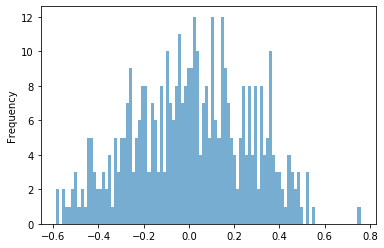

In [18]:
data_df['CosTheta'].plot.hist(bins=100, alpha=0.6)


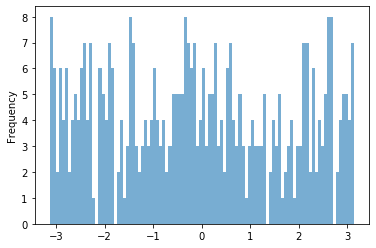

In [19]:
data_df['Phi'].plot.hist(bins=100, alpha=0.6)


## Probe matrix
The probe matrix \\(\rho(l)\\) is defined as follows:
\\[\rho(l) = \frac{1+a}{3}\cdot \delta_{ij} - a{\cdot}l_i\cdot l_j - ib\cdot \epsilon_{ijk}\cdot l_k,\\]
where \\(a = 0.5\\) and \\(b = c_A{\cdot}c_V = \sin^2\theta_W \simeq 0.22\\).

In [26]:
def ProbeMatrix( CosTheta, Phi, returnValue ):
    rho      = np.array([[-999.j, -999.j, -999.j], [-999.j, -999.j, -999.j], [-999.j, -999.j, -999.j]])
    SinTheta = math.sqrt(1 - CosTheta*CosTheta)
    CosPhi   = math.cos(Phi)
    SinPhi   = math.sin(Phi)
    l = [ SinTheta*CosPhi, SinTheta*SinPhi, CosTheta ]
    for i in range(0,3):
        for j in range(0,3):
            for k in range(0,3):
                epsilon = LeviCivita(i,j,k)
                delta = -999.
                if i == j:
                    delta = 0.5
                else:
                    delta = 0.
                rho[i][j] = delta - 0.5*l[i]*l[j]- (1j)*0.22*epsilon*l[k]
    if returnValue == 0:
        return rho 
    elif returnValue == 1:
        return rho[0][0]
    elif returnValue == 2:
        return rho[0][1]
    elif returnValue == 3:
        return rho[0][2]
    elif returnValue == 4:
        return rho[0][3]
    elif returnValue == 5:
        return rho[1][0]
    elif returnValue == 6:
        return rho[1][1]
    elif returnValue == 7:
        return rho[1][2]
    elif returnValue == 8:
        return rho[2][0]
    elif returnValue == 9:
        return rho[2][1]
    elif returnValue == 10:
        return rho[2][2]

    

In [28]:
Probe = ProbeMatrix( -0.419608,  -2.426581, 0 )
Probe

array([[ 0.26511665+0.j        , -0.20394467+0.09231376j,
        -0.14379867+0.j        ],
       [-0.20394467-0.09231376j,  0.32291879+0.j        ,
        -0.12485761+0.j        ],
       [-0.14379867+0.j        , -0.12485761+0.j        ,
         0.41196456+0.j        ]])

In [23]:
for j in range(0,3):
    print(1j)

1j
1j
1j


In [21]:
# df_Rapidity_gen = df_gener.query('fMCTrkTrkM > 2.8 & fMCTrkTrkM < 3.3 & fMCTrkTrkY < -2.5 & fMCTrkTrkY > -4.0 ')
df_Rapidity_gen = df_gener.query('fMCTrkTrkY < -2.5 & fMCTrkTrkY > -4.0 ')
generatedevents_Ycut = len(df_Rapidity_gen.index)
generatedevents_Ycut

NameError: name 'df_gener' is not defined

In [ ]:
InvMass_recon = df_recon['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
# minv_bkgMine = df_backgroundMine['fInvariantMassDimuon'].plot.hist(bins=100, alpha=0.6)


In [ ]:
InvMass_gen = df_gener['fMCTrkTrkM'].plot.hist(bins=100, alpha=0.6)


### Pandas 

Pandas is a library that provides data structures and analysis tools for Pyhton. The two primary data structures of pandas are **Series** (1-dimensional) and **DataFrame** (2-dimensional) and we will work with them.

- **Series** are 1-dimensional ndarray with axis labels.
- **DataFrame** are 2-dimensional tabular data structure with labeled axes (rows and columns).

For more details: https://pandas.pydata.org/pandas-docs/stable/





One of the most interesting tool of DataFrame is the *query()* method (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html). With this method we can query the DataFrame getting elements which **satisfy a boolean expression**.

A "trick" to plot more than one distribution is to create a new dataframe with the data to plot in different columns

In [ ]:
#dataframe with invariant-mass of background and signal
# df_new = pd.concat([df_background['InvMass'], df_signal['InvMass']], axis=1)
# df_new.head()

In [ ]:
# minv_compared = df_new.plot.hist(bins=100, alpha=0.6)

## Data preparation
We need to tell at the model what is signal and what is background.

So we add a 'y' column and label signal and background with **y=1** for signal and **y=0** for background. Then we stack togheter signal and background. This will be the reference for the ML model. 

In [ ]:
plot_VZERO = df_recon['fV0TotalNCells'].plot.hist(bins=100, alpha=0.6)


In [ ]:
plot_fL0inputs = df_recon['fL0inputs'].plot.hist(bins=100, alpha=0.6)


In [ ]:
def return0MSL(x):
    return ((x & (1<<5))>>5)

In [ ]:
def return0MUL(x):
    return ((x & (1<<13))>>13)

In [ ]:
df_recon['f0MSL'] = df_recon.fL0inputs.apply(return0MSL)
plot_0MSL = df_recon['f0MSL'].plot.hist(bins=100, alpha=0.6)


In [ ]:
df_recon['f0MUL'] = df_recon.fL0inputs.apply(return0MUL)
plot_0MUL = df_recon['f0MUL'].plot.hist(bins=100, alpha=0.6)


In [ ]:
len(df_recon.index)

In [ ]:
df_InvMassCutPlusRapidity_for0MUL = df_recon.query('fTrkTrkY < -2.5 & fTrkTrkY > -4.0 ')
plot_0MUL_rightrapidity = df_InvMassCutPlusRapidity_for0MUL['f0MUL'].plot.hist(bins=100, alpha=0.6)
len(df_InvMassCutPlusRapidity_for0MUL.index)

In [ ]:
df_InvMassCutPlusRapidity = df_recon.query('fTrkTrkM > 2.8 & fTrkTrkM < 3.3 & fTrkTrkY < -2.5 & fTrkTrkY > -4.0 ')
df_InvMassCutPlusTriggerConditionPlusRapidity = df_InvMassCutPlusRapidity.query('f0MUL > 0.5')
df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
reconstructedevents = len(df_InvMassCutPlusTriggerConditionPlusRapidity.index)
reconstructedevents
# len(df_InvMassCutPlusRapidity.index)

In [ ]:
InvMass_recAfterCuts = df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkM'].plot.hist(bins=100, alpha=0.6)
len(df_InvMassCutPlusTriggerConditionPlusRapidity.index)

In [ ]:
AxE = reconstructedevents/generatedevents_Ycut
AxE

### Template for Pt distr

In [ ]:
bins = np.arange(0,5, 0.10)

In [ ]:
df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkPt'].hist(bins=bins)

In [ ]:
PtDistr = df_InvMassCutPlusTriggerConditionPlusRapidity['fTrkTrkPt'].to_numpy()

In [ ]:
counts, edges, plot = plt.hist(PtDistr, bins=bins)

In [ ]:
counts

Now we can fit the distribution and extract the signal

In [ ]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=[2.96, 3.05])
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(2.96, 3.05, 0.00001)
    r_red = np.arange(2.98, 3.005, 0.0001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 2.99, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r_red, gaus_function(r_red, N=popt[2], mu=popt[3], sigma=popt[4]), label='gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+gauss', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, 2.98, 3.005, args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, 2.98, 3.005, args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.title(f'significance: {significance:.1f}')
    plt.legend()
    plt.xlabel('$M_{^{3}He+\pi}$ $(\mathrm{GeV/}c^2)$')
    plt.ylabel('counts / 2.25 $\mathrm{MeV/}c^2$')
    plt.show()

In [ ]:
fit_invmass(inv_sel_simple)

### Optimized model
We can optimize the hyper-parameters to have a **more complex model**

## Final Excercise

Using the query function of pandas perform the "standard" selections

In [ ]:
df_lin_sel = df_data.query('V0CosPA > 0.995')
inv_mass_lin_sel = df_lin_sel['InvMass']

In [ ]:
fit_invmass(inv_mass_lin_sel)

In [ ]:
import ROOT